### Unsupervised Learning
### Implementing Principal Component Analysis & K-means Clustering

In [126]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [127]:
data = pd.read_csv("Iris Dataset.csv")

In [128]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [129]:
data.info

<bound method DataFrame.info of       Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-seto

### Data Preprocessing
#### Removing Species column and standardizing the data for PCA 

In [130]:
species = data['Species']

In [156]:
X = data.drop(columns=['Species']).values
# .values convert this dataframe into numpy array as both PCA and K-means will require an array to procede with 

In [158]:
# Standardize the data for PCA
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_stdized = (X - X_mean) / X_std
# It's important and beneficial to standardize the data before PCA

#### Pricipal Component Analysis

In [133]:
# PCA reduces dimensionality by projecting data to new axes of maximum variance, it is achieved in following steps

def pca(X, num_components=3):
    cov_mat = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
    
    # Sort by descending eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Project data
    projected = X @ eigenvectors[:, :num_components]
    
    return projected, eigenvalues[:num_components], eigenvectors[:, :num_components]

X_pca, eigvals, eigvecs = pca(X_stdized)
print("Top 3 Eigenvalues:", eigvals)


Top 3 Eigenvalues: [3.7603354  0.92794917 0.23570257]


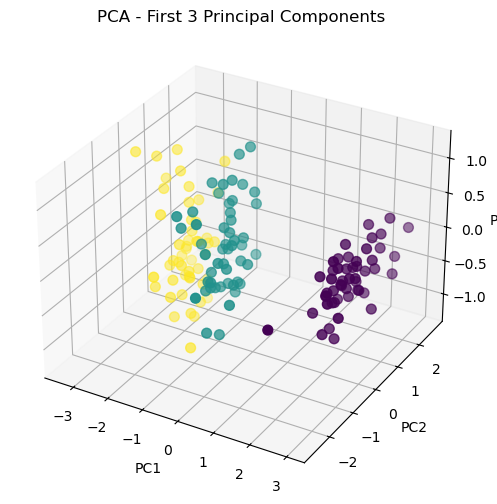

In [134]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Encode species to integers for color
label_map = {label: idx for idx, label in enumerate(np.unique(species))}
colors = [label_map[label] for label in species]

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, cmap='viridis', s=50)
ax.set_title("PCA - First 3 Principal Components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()
# You can see 3 distinct clusters, suggesting that PCA has effectively reduced the dimensions of the data while keeping the clusters of species separable.

#### K-means Algorithm for Clustering 

In [135]:
def k_means(X, k, max_iters=100):
    # Randomly initialize k centroids
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        # Assign clusters
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute new centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Break if no change
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
        
    return labels, centroids

In [136]:
k = 3
predicted_labels, centroids = k_means(X_stdized, k=k)

In [137]:
# Convert actual species to numeric labels
true_labels = np.array([label_map[label] for label in species])

# Since cluster labels are arbitrary, map them to true labels for better accuracy comparison
from scipy.stats import mode

def map_labels(pred, true):
    label_map = {}
    for i in np.unique(pred):
        match = mode(true[pred == i], keepdims=False).mode  # Use `.mode` to access the value
        label_map[i] = match
    return np.vectorize(label_map.get)(pred)


mapped_preds = map_labels(predicted_labels, true_labels)
accuracy = np.mean(mapped_preds == true_labels)
print(f"Clustering Accuracy (after label mapping): {accuracy:.2f}")


Clustering Accuracy (after label mapping): 0.96


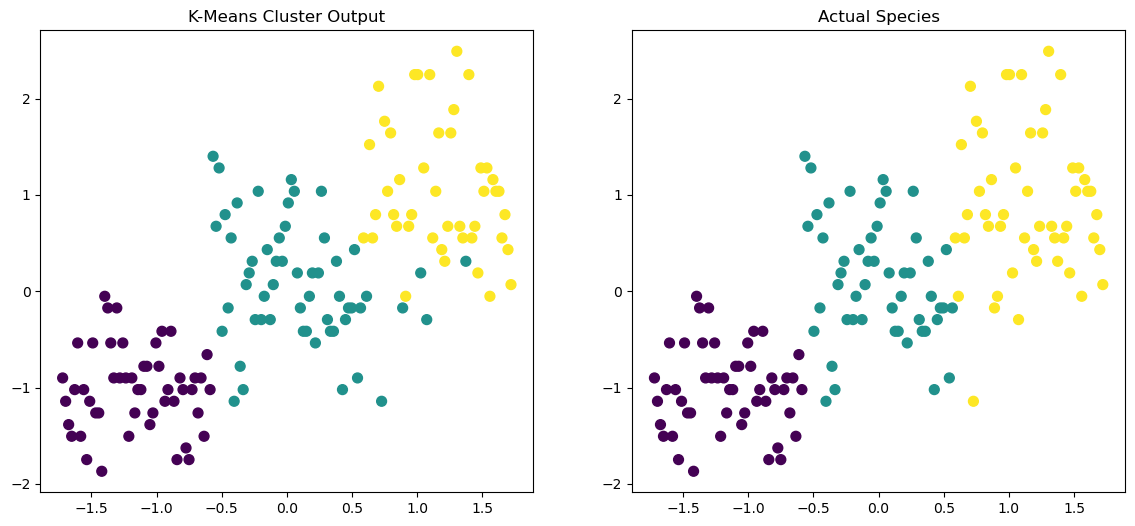

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(X_stdized[:, 0], X_stdized[:, 1], c=mapped_preds, cmap='viridis', s=50)
ax1.set_title("K-Means Cluster Output")

ax2.scatter(X_stdized[:, 0], X_stdized[:, 1], c=true_labels, cmap='viridis', s=50)
ax2.set_title("Actual Species")

plt.show()